# Spatial Cluster Analysis with R
By Lorenz Menendez & Isaac Kamber

The goal of this Notebook is to show how we used [electoral and geographic data](https://github.com/isaacnk/GIS3/blob/master/Election%20Data%20Cleaning%20and%20Merging.ipynb) to compute cluster maps in GeoDa, which could then be reimported back into R for a later [Factor Analysis](https://github.com/isaacnk/2016Election/blob/master/Notebooks/Factor%20Analysis.ipynb).

## Libraries

In [2]:
library(sf)
library(dplyr)

Warning message:
“package ‘sf’ was built under R version 3.4.4”Linking to GEOS 3.6.1, GDAL 2.1.3, PROJ 4.9.3
Warning message:
“package ‘dplyr’ was built under R version 3.4.4”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Data Import & Quality Control
The first step is to import the election data we previously wrangled.

In [3]:
elctnVotes16 = st_read("http://raw.githubusercontent.com/isaacnk/2016Election/master/Notebooks/DATA/county_level_election_results_2016.geojson")

Reading layer `OGRGeoJSON' from data source `http://raw.githubusercontent.com/isaacnk/2016Election/master/Notebooks/DATA/county_level_election_results_2016.geojson' using driver `GeoJSON'
Simple feature collection with 3233 features and 12 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -179.1473 ymin: -14.55255 xmax: 179.7785 ymax: 71.35256
epsg (SRID):    4269
proj4string:    +proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs


After importing, it's best practice to view the geometric and attribute values. This is to make sure that nothing went wrong during a previous export or that data wasn't lost somehow. Let's start by librarying leaflet and creating our map! 

In [9]:
library(leaflet)

Warning message:
“package ‘leaflet’ was built under R version 3.4.4”

In [25]:
map = leaflet(data = elctnVotes16) %>%
    addTiles() %>%
    addPolygons(weight = .25)

map

Warning message:
“sf layer has inconsistent datum (+proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs).
Need '+proj=longlat +datum=WGS84'”

HTML widgets cannot be represented in plain text (need html)

We can confirm that all the relevant data is present using the *summary()* and *head()* functions

In [26]:
summary(elctnVotes16)

      FIPS          STATEFP        COUNTYF         COUNTYN    
 Min.   : 1001   48     : 254   001    :  50   00023901:   1  
 1st Qu.:19039   13     : 159   003    :  50   00025441:   1  
 Median :30037   51     : 133   005    :  50   00025442:   1  
 Mean   :31539   21     : 120   009    :  49   00025443:   1  
 3rd Qu.:46127   29     : 115   007    :  48   00025444:   1  
 Max.   :78030   20     : 105   013    :  48   00025445:   1  
                 (Other):2347   (Other):2938   (Other) :3227  
           AFFGEOI         GEOID              NAME           LSAD     
 0500000US01001:   1   01001  :   1   Washington:  31   06     :3007  
 0500000US01003:   1   01003  :   1   Franklin  :  26   13     :  78  
 0500000US01005:   1   01005  :   1   Jefferson :  26   15     :  64  
 0500000US01007:   1   01007  :   1   Jackson   :  24   25     :  40  
 0500000US01009:   1   01009  :   1   Lincoln   :  24   04     :  13  
 0500000US01011:   1   01011  :   1   Madison   :  20   05     :  10  

In [27]:
head(elctnVotes16)

FIPS  STATEFP COUNTYF COUNTYN  AFFGEOI        GEOID NAME        LSAD
1  1059 01      059     00161555 0500000US01059 01059 Franklin    06  
2 13111 13      111     00351094 0500000US13111 13111 Fannin      06  
3 19109 19      109     00465243 0500000US19109 19109 Kossuth     06  
4 40115 40      115     01101845 0500000US40115 40115 Ottawa      06  
5 42115 42      115     01213688 0500000US42115 42115 Susquehanna 06  
6 40053 40      053     01101814 0500000US40053 40053 Grant       06  
  ALAND      AWATER   pct_hll   pct_trm   geometry                      
1 1641580723 32904833 0.1824751 0.7862126 MULTIPOLYGON (((-88.16591 3...
2 1002370118 13560697 0.1628005 0.8154419 MULTIPOLYGON (((-84.62148 3...
3 2519332669 4154722  0.2954572 0.6567910 MULTIPOLYGON (((-94.44314 4...
4 1219467406 35708892 0.2417212 0.7138447 MULTIPOLYGON (((-95.03412 3...
5 2132881515 22356541 0.2715899 0.6834014 MULTIPOLYGON (((-76.1312 41...
6 2592245098 7021964  0.1308496 0.8300772 MULTIPOLYGON (((-98.11199 3...

We're satisfied that all of our data is intact, so we'll proceeed to cluster analysis. This data verification step will not be repeated in future data imports.

## Cluster Analysis in R
This part of the tutorial will shot you how to look for spatial autocorrelations using the Local Moran's I medthod to generate a LISA cluster map. The steps taken are adapted from a Lab in our GIS II class created by Dr. Marynia Kolak at the University of Chicago and from [Practical 9: Measuring Spatial Autocorrelation in R (Lansley & CHeshire, 2016)](https://data.cdrc.ac.uk/tutorial/aa5491c9-cbac-4026-97c9-f9168462f4ac/31d1831b-56d2-4ab9-b48e-72c46d2e826c)

### I. Create a spatial weight matrix for U.S. Counties
The following code will create a Queen contiguity spatial weight matrix for U.S. counties. It will automatically filter for counties that have no neighbors, which we anticipate will happen for counties non-countiguous areas (like the Hawaiian Islands, for example). For this operation, we library the 'spdep' package.

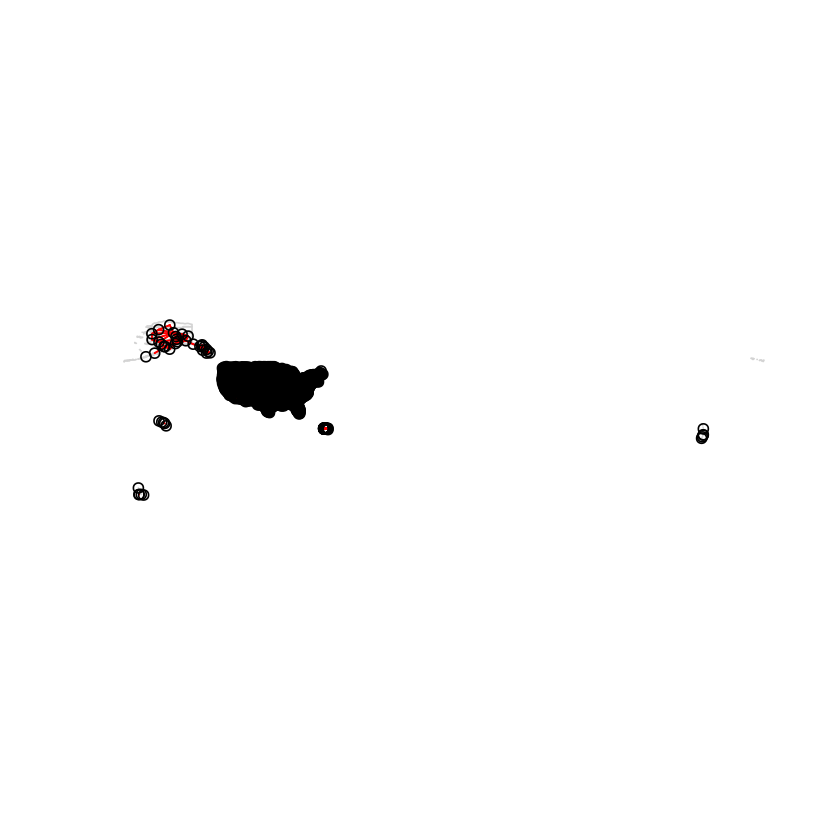

In [41]:
library(spdep)

st_geometry(elctnVotes16) %>%
plot(border = 'lightgrey')

queenData = poly2nb(elctnVotes16)
queenData

plot(queenData, coordinates(as(elctnVotes16, 'Spatial')), add = TRUE, col = 'red')

queenData = nb2listw(queenData, zero.policy = TRUE)


Now, we are going to run the Moran's I using the spatial weight be just created. We want to make sure that we have a low p-value before creating the LISA map.

In [46]:
moran.test(elctnVotes16$pct_hll, listw = queenData, zero.policy = TRUE, na.action = na.omit)


	Moran I test under randomisation

data:  elctnVotes16$pct_hll  
weights: queenData 
omitted: 53, 77, 78, 91, 93, 105, 113, 117, 123, 136, 168, 175, 186, 204, 237, 251, 309, 310, 398, 508, 509, 510, 517, 518, 524, 539, 542, 543, 546, 573, 589, 617, 666, 703, 718, 719, 722, 739, 802, 829, 830, 848, 850, 880, 882, 883, 894, 896, 929, 934, 1004, 1014, 1115, 1133, 1178, 1181, 1183, 1248, 1253, 1271, 1290, 1315, 1320, 1387, 1417, 1423, 1426, 1443, 1485, 1610, 1611, 1694, 1695, 1959, 1974, 1975, 1976, 1995, 2018, 2037, 2069, 2130, 2131, 2153, 2242, 2255, 2339, 2340, 2341, 2344, 2364, 2365, 2396, 2398, 2482, 2483, 2534, 2561, 2563, 2564, 2587, 2588, 2590, 2591, 2623, 2625, 2651, 2815, 2816, 2842, 2856, 2898, 2934, 3013, 3049, 3114, 3178, 3199, 3216, 3226, 3232, 3233 n reduced by no-neighbour observations
  

Moran I statistic standard deviate = 55.692, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.5990113978 

### II. Building the LISA Map
The following code will calucate Local Moran's I statistics for each county and then column bind it to the original dataset.

In [62]:
Lisa = localmoran(x = elctnVotes16$pct_hll, listw = queenData, zero.policy = TRUE, na.action = na.exclude)
        
lisaMap = cbind(elctnVotes16, Lisa)
head(lisaMap)

FIPS  STATEFP COUNTYF COUNTYN  AFFGEOI        GEOID NAME        LSAD
1  1059 01      059     00161555 0500000US01059 01059 Franklin    06  
2 13111 13      111     00351094 0500000US13111 13111 Fannin      06  
3 19109 19      109     00465243 0500000US19109 19109 Kossuth     06  
4 40115 40      115     01101845 0500000US40115 40115 Ottawa      06  
5 42115 42      115     01213688 0500000US42115 42115 Susquehanna 06  
6 40053 40      053     01101814 0500000US40053 40053 Grant       06  
  ALAND      AWATER   pct_hll   pct_trm   Ii          E.Ii          Var.Ii   
1 1641580723 32904833 0.1824751 0.7862126  0.88189608 -0.0003215434 0.1662552
2 1002370118 13560697 0.1628005 0.8154419  0.98577468 -0.0003215434 0.1424586
3 2519332669 4154722  0.2954572 0.6567910  0.02792633 -0.0003215434 0.1107298
4 1219467406 35708892 0.2417212 0.7138447  0.36051014 -0.0003215434 0.1995705
5 2132881515 22356541 0.2715899 0.6834014 -0.07299094 -0.0003215434 0.1662552
6 2592245098 7021964  0.1308496 0.8300772  1.09599977 -0.0003215434 0.1995705
  Z.Ii        Pr.z...0.   geometry                      
1  2.16365526 0.015245408 MULTIPOLYGON (((-88.16591 3...
2  2.61261212 0.004492661 MULTIPOLYGON (((-84.62148 3...
3  0.08488941 0.466174657 MULTIPOLYGON (((-94.44314 4...
4  0.80771191 0.209628222 MULTIPOLYGON (((-95.03412 3...
5 -0.17822305 0.570726096 MULTIPOLYGON (((-76.1312 41...
6  2.45408549 0.007062170 MULTIPOLYGON (((-98.11199 3...

You will notice that there are new 'li', 'E.', 'Var.li' ... columnns added to the original dataset. You could eventually plot this to find a significance map.

This code will plot a LISA map based on the statistics we just calculated for every county in the U.S.

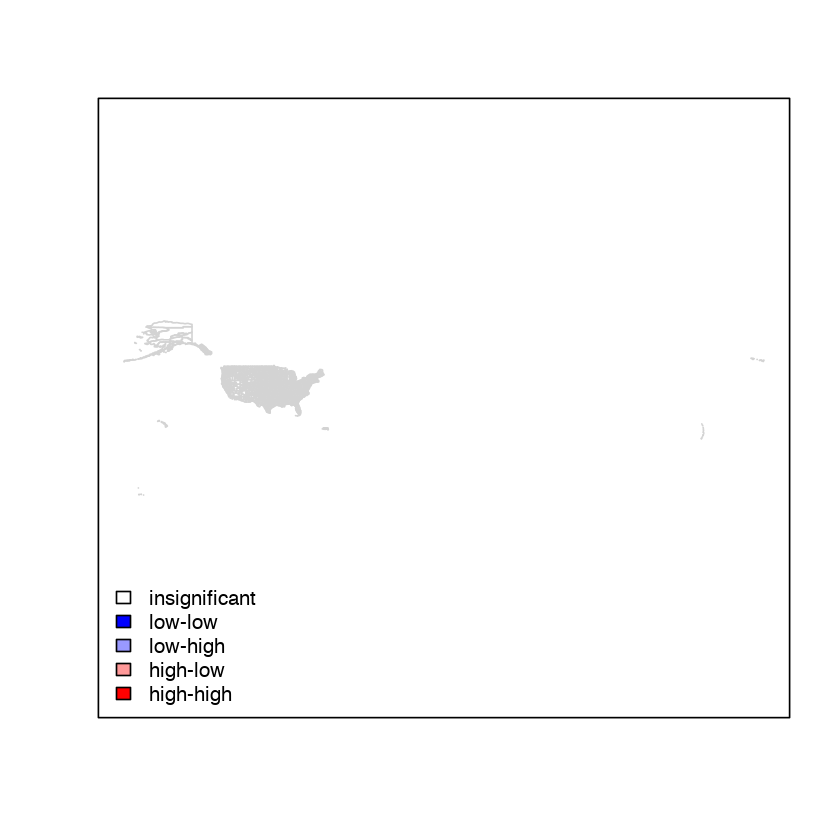

In [58]:
### to create LISA cluster map ### 
quadrant <- vector(mode="numeric",length=nrow(Lisa))

# centers the variable of interest around its mean
Mean <- elctnVotes16$pct_hll - mean(elctnVotes16$pct_hll)     

# centers the hllLisa Moran's around the mean
m.Lisa <- Lisa[,1] - mean(Lisa[,1])    

# significance threshold
signif <- .1

# builds a data quadrant
quadrant[Mean >0 & m.Lisa>0] <- 4  
quadrant[Mean <0 & m.Lisa<0] <- 1      
quadrant[Mean <0 & m.Lisa>0] <- 2
quadrant[Mean >0 & m.Lisa<0] <- 3
quadrant[Lisa[,5]>signif] <- 0   

# plot in r
brks <- c(0,1,2,3,4)
colors <- c("white","blue",rgb(0,0,1,alpha=0.4),rgb(1,0,0,alpha=0.4),"red")
plot(st_geometry(elctnVotes16),border="lightgray",col=colors[findInterval(quadrant,brks,all.inside=FALSE)])
box()
legend("bottomleft",legend=c("insignificant","low-low","low-high","high-low","high-high"),
       fill=colors,bty="n")
        

As you can see, there are around 70 counties that like in the 'low-high' or 'high-low' outlier categories. This means that these counties have ver different voting patterns that most of their surrounding counties, making them an interesting case study for future Factor Analysis.

## On using GeoDa for LISA Analysis
Due to the fact that R does not have a very intuitive way to conduct the LISA analysis, we proceeded to use GeoDa to run find outlying counties for the actual project and subsequent factor analysis. Even though this does become slightly less reproducible, it made for a much better data workflow.